In [2]:
import geopandas as gpd
import os
import glob
import pdal

## Selecionando as Quadrículas para Processamento

In [3]:
gdf_quadriculas = gpd.read_file('zip://dados/SIRGAS_SHP_quadriculamdt.zip!SIRGAS_SHP_quadriculamdt', epsg='31983')

In [4]:
gdf_quadriculas.set_crs(epsg='31983', inplace=True)

,qmdt_cod,geometry
0,3212-353,"POLYGON ((329132.004 7367829.458, 329125.190 7..."
1,3212-344,"POLYGON ((328601.255 7367823.210, 328594.420 7..."
2,3212-343,"POLYGON ((328070.502 7367816.960, 328063.648 7..."
3,3211-464,"POLYGON ((327539.756 7367810.622, 327532.876 7..."
4,3211-463,"POLYGON ((327008.999 7367804.285, 327002.102 7..."
...,...,...
5357,3234-241,"POLYGON ((331960.582 7352864.137, 331967.325 7..."
5358,3234-224,"POLYGON ((333544.473 7353459.402, 333551.152 7..."
5359,3336-444,"POLYGON ((331725.429 7373051.662, 332256.363 7..."
5360,3336-442,"POLYGON ((331718.736 7373628.441, 332249.692 7..."


In [5]:
gdf_marcos = gpd.read_file('dados/SIRGAS_GPKG_apoiocampo.gpkg')

In [6]:
gdf_quadriculas_marcos = gdf_quadriculas.sjoin(gdf_marcos, how='inner')

<Axes: >

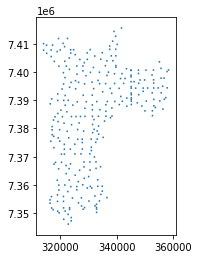

In [7]:
gdf_quadriculas_marcos.plot()

## Processando as Quadrículas selecionadas

In [8]:
DATA_2020 = "/media/fernando/DATA/LiDAR-Sampa-2020"
DATA_2017 = "/media/fernando/DATA/LiDAR-Sampa-2017"

In [10]:
glob.glob(f'{DATA_2017}/*')

[]

In [29]:
options = Options()
options.add_experimental_option("prefs", {
  "download.default_directory": cwd+"\ortofotos",
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True
})

In [30]:
driver = webdriver.Chrome(chrome_options=options)

/tmp/ipykernel_64518/2553989415.py:1: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 96
Current browser version is 119.0.6045.105 with binary path /usr/bin/google-chrome
Stacktrace:
#0 0x55bd0058eee3 <unknown>
#1 0x55bd0005c608 <unknown>
#2 0x55bd00083476 <unknown>
#3 0x55bd0007ec07 <unknown>
#4 0x55bd0007b46f <unknown>
#5 0x55bd000b5f45 <unknown>
#6 0x55bd000b0163 <unknown>
#7 0x55bd00085bfc <unknown>
#8 0x55bd00086c05 <unknown>
#9 0x55bd005c0baa <unknown>
#10 0x55bd005d6651 <unknown>
#11 0x55bd005c1b05 <unknown>
#12 0x55bd005d7a68 <unknown>
#13 0x55bd005b605f <unknown>
#14 0x55bd005f2818 <unknown>
#15 0x55bd005f2998 <unknown>
#16 0x55bd0060deed <unknown>
#17 0x7fe2e3e06609 <unknown>


In [ ]:
for i, quadricula in gdf_quadriculas_marcos.iterrows():
    q = quadricula.qmdt_cod
    d = f"https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadMapaArticulacao&arq=MDS_2020%5C{q}.zip&arqTipo=MAPA_ARTICULACAO"
    if len(glob.glob(f'{DATA_2020}/MDS_{q}*.laz')) < 1:
        print(d)
        driver.get(d)
        # print(f'baixando {q}')
        # urllib.request.urlretrieve(d, f'{DATA_2020}/{q.split("-")[0]}/MDS_{q}_1000.laz')
    # break

NameError: name 'glob' is not defined